In [ ]:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday

# Load the CSV files
umsatz_df = pd.read_csv('umsatzdaten_gekuerzt.csv')
kiwo_df = pd.read_csv('kiwo.csv')
wetter_df = pd.read_csv('wetter.csv')

# Display the first few rows and column names to understand the structure
umsatz_df.head(), kiwo_df.head(), wetter_df.head()

(        id       Datum  Warengruppe      Umsatz
 0  1307011  2013-07-01            1  148.828353
 1  1307021  2013-07-02            1  159.793757
 2  1307031  2013-07-03            1  111.885594
 3  1307041  2013-07-04            1  168.864941
 4  1307051  2013-07-05            1  171.280754,
         Datum  KielerWoche
 0  2012-06-16            1
 1  2012-06-17            1
 2  2012-06-18            1
 3  2012-06-19            1
 4  2012-06-20            1,
         Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
 0  2012-01-01         8.0      9.8250                   14        58.0
 1  2012-01-02         7.0      7.4375                   12         NaN
 2  2012-01-03         8.0      5.5375                   18        63.0
 3  2012-01-04         4.0      5.6875                   19        80.0
 4  2012-01-05         6.0      5.3000                   23        80.0)

In [20]:
# Convert Datum columns to datetime format
umsatz_df['Datum'] = pd.to_datetime(umsatz_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])

# Merge umsatz_df with kiwo_df
merged_df = pd.merge(umsatz_df, kiwo_df, on='Datum', how='left')

# Merge the result with wetter_df
merged_df = pd.merge(merged_df, wetter_df, on='Datum', how='left')

# Fill missing 'KielerWoche' and 'Wettercode' with 0 (assume not during Kieler Woche or no weather data)
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)
merged_df['Wettercode'] = merged_df['Wettercode'].fillna(0)

# Add date-related features
merged_df['Wochentag'] = merged_df['Datum'].dt.day_name() # Day of the week
merged_df['Monat'] = merged_df['Datum'].dt.month
merged_df['Jahr'] = merged_df['Datum'].dt.year
merged_df['Kalenderwoche'] = merged_df['Datum'].dt.isocalendar().week




Adding Seasons

In [21]:
# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Fruehling'
    elif month in [6, 7, 8]:
        return 'Sommer'
    else:
        return 'Herbst'

merged_df['Jahreszeit'] = merged_df['Monat'].apply(get_season)

Add Public Holiday Indicator

In [24]:

# Define German holidays
class GermanHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('Neujahr', month=1, day=1, observance=nearest_workday),
        Holiday('Tag der Arbeit', month=5, day=1, observance=nearest_workday),
        Holiday('Tag der Deutschen Einheit', month=10, day=3, observance=nearest_workday),
        Holiday('Erster Weihnachtstag', month=12, day=25, observance=nearest_workday),
        Holiday('Zweiter Weihnachtstag', month=12, day=26, observance=nearest_workday)
    ]


# Add holiday indicator
years = merged_df['Jahr'].unique()
start_date = f"{years.min()}-01-01"
end_date = f"{years.max()}-12-31"
calendar = GermanHolidayCalendar()
holidays = calendar.holidays(start=start_date, end=end_date)
merged_df['Feiertag'] = merged_df['Datum'].isin(holidays).astype(int)


In [23]:
merged_df.head()

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Wochentag,Monat,Jahr,Kalenderwoche,Jahreszeit,Feiertag
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,20.0,Monday,7,2013,27,Sommer,0
1,1307021,2013-07-02,1,159.793757,0.0,3.0,17.3125,10.0,0.0,Tuesday,7,2013,27,Sommer,0
2,1307031,2013-07-03,1,111.885594,0.0,7.0,21.0750,6.0,61.0,Wednesday,7,2013,27,Sommer,0
3,1307041,2013-07-04,1,168.864941,0.0,7.0,18.8500,7.0,20.0,Thursday,7,2013,27,Sommer,0
4,1307051,2013-07-05,1,171.280754,0.0,5.0,19.9750,12.0,0.0,Friday,7,2013,27,Sommer,0


Correlation matrix to choose the best independent variables

In [31]:
import statsmodels.api as sm

# Calculate correlation matrix with Umsatz
correlation_matrix = merged_df.corr(numeric_only=True)
correlation_with_target = correlation_matrix["Umsatz"].sort_values(ascending=False)

correlation_with_target


Umsatz                 1.000000
Temperatur             0.222935
KielerWoche            0.058244
Windgeschwindigkeit    0.014705
Monat                  0.013889
Feiertag               0.009658
Kalenderwoche          0.001969
Wettercode            -0.050156
Warengruppe           -0.062589
Jahr                  -0.086726
id                    -0.086929
Bewoelkung            -0.089916
Name: Umsatz, dtype: float64

only 'Temperatur' has reasonable correlation with Umsatz 

Then, applying simple linear regression model(Umsatz as a dependent, Temperatur as an independent variable) :

In [34]:
# Drop rows with missing Temperatur or Umsatz directly from merged_df
merged_df_clean = merged_df.dropna(subset=['Temperatur', 'Umsatz'])

# Define X and y from merged_df directly
X = sm.add_constant(merged_df_clean['Temperatur'])  # Add intercept
y = merged_df_clean['Umsatz']

# Fit the model
model = sm.OLS(y, X).fit()

# Display the summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Umsatz   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     487.2
Date:                Mon, 19 May 2025   Prob (F-statistic):          2.77e-105
Time:                        14:01:59   Log-Likelihood:                -59330.
No. Observations:                9318   AIC:                         1.187e+05
Df Residuals:                    9316   BIC:                         1.187e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        153.1775      2.834     54.055      0.000     147.623     158.732
Temperatur     4.4565      0.202     22.073      0.000       4.061       4.852
==============================================================================
Omnibus:                     3943.152   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36463.361
Skew:                           1.785   Prob(JB):                         0.00
Kurtosis:                      12.010   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R2 = 0.05 -> Temperatur explains 5% of the Umsatz variance.

In [39]:
### Optional -> Plotting the results:

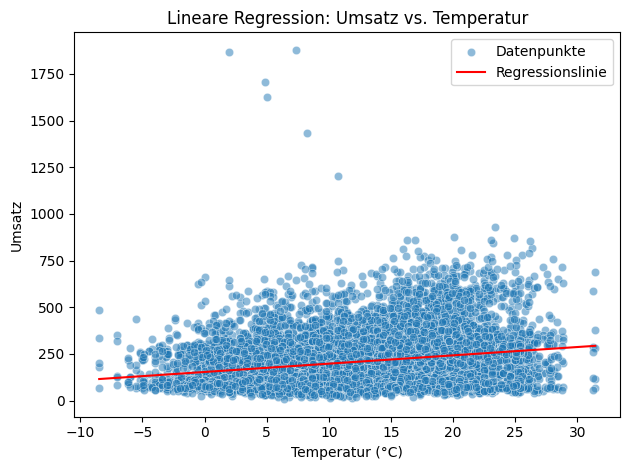

In [36]:
# Plot regression line: Umsatz vs Temperatur
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
sns.scatterplot(data=merged_df_clean, x='Temperatur', y='Umsatz', alpha=0.5, label='Datenpunkte')

# Regression line
temperatur_range = pd.DataFrame({'Temperatur': sorted(merged_df_clean['Temperatur'])})
temperatur_range_with_const = sm.add_constant(temperatur_range)
predicted_umsatz = model.predict(temperatur_range_with_const)

plt.plot(temperatur_range['Temperatur'], predicted_umsatz, color='red', label='Regressionslinie')

# Labels and legend
plt.title('Lineare Regression: Umsatz vs. Temperatur')
plt.xlabel('Temperatur (°C)')
plt.ylabel('Umsatz')
plt.legend()
plt.tight_layout()
plt.show()
